# Imports

In [77]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from skimage.feature import hog
import torchvision.utils
import pandas as pd
import numpy as np
import random
from PIL import Image, ImageChops
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tensorboardX import SummaryWriter
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Helper Functions

In [2]:
def imshow(img, text=None, should_save=False):
    npimg = img.numpy()
    plt.axis('off')
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

# Configuration Class

In [113]:
class Config():
    train_dir = '/data/rgbd_face_data/kinect_cropped/train'
    test_dir = '/data/rgbd_face_data/kinect_cropped/test'
    train_batch_size = 32
    train_number_epochs = 50

# Custom Dataset Class

In [114]:
class FaceIdDataset(Dataset):
    
    def __init__(self, imageFolderDataset, transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        
    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        should_get_same_face = random.randint(0,1)
        
        if should_get_same_face:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break
        
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        depth0 = np.load(img0_tuple[0][:-5] + "d.npy")
        depth1 = np.load(img1_tuple[0][:-5] + "d.npy")

        rgbd0 = np.dstack((np.asarray(img0), depth0/255))
        rgbd1 = np.dstack((np.asarray(img1), depth1/255))
        
        hog0 = np.load(img0_tuple[0][:-5] + "h.npy")
        hog1 = np.load(img1_tuple[0][:-5] + "h.npy")
        rgbd0 = np.dstack((rgbd0, hog0))
        rgbd1 = np.dstack((rgbd1, hog1))

        if self.transform is not None:
            rgbd0 = self.transform(rgbd0)
            rgbd1 = self.transform(rgbd1)
        
        return rgbd0, rgbd1, torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [115]:
train_folders = dset.ImageFolder(root=Config.train_dir)

train_dataset = FaceIdDataset(imageFolderDataset=train_folders,
                              transform=transforms.Compose([transforms.ToTensor()]))

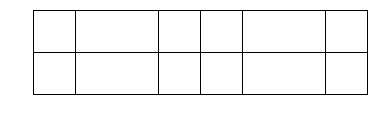

[[1. 1. 1. 0. 1. 1. 0. 1.]]


In [116]:
vis_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=1,
                        batch_size=8)

dataiter = iter(vis_dataloader)

example_batch = next(dataiter)

concatenated = torch.cat((example_batch[0][:,:3,:,:],example_batch[1][:,:3,:,:]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape((1,8)))

# Neural Network Architecture

In [117]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(5, 10, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(10),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(10, 20, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(20),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(20, 20, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(20))
        
        self.fc1 = nn.Sequential(
            nn.Linear(20*100*100, 512),
            nn.ReLU(inplace=True),
 
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256, 128))
        
    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

# Contrastive Loss Function

In [118]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, output0, output1, label):
        l2_norm = F.pairwise_distance(output0, output1)
        contrastive_loss = torch.mean((1-label) * torch.pow(l2_norm, 2) + 
                                      (label) * torch.pow(torch.clamp(self.margin - l2_norm, min=0.0), 2))
        
        return contrastive_loss

# Train...

In [119]:
train_dataloader = DataLoader(train_dataset,
                              shuffle=True,
                              num_workers=1,
                              #batch_size=Config.train_batch_size)
                              batch_size=32)

In [20]:
nnet = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(nnet.parameters(), lr = 0.0001)
#writer = SummaryWriter()

In [120]:
counter = []
loss_history = []
iteration = 0

Epoch number 0
 Current loss 1.0334804058074951

Epoch number 0
 Current loss 1.0264750719070435

Epoch number 0
 Current loss 1.0228255987167358

Epoch number 0
 Current loss 1.0647119283676147

Epoch number 0
 Current loss 0.9946102499961853

Epoch number 1
 Current loss 1.0515639781951904

Epoch number 1
 Current loss 0.9819340705871582

Epoch number 1
 Current loss 1.0298799276351929

Epoch number 1
 Current loss 1.050010085105896

Epoch number 1
 Current loss 1.022518515586853

Epoch number 2
 Current loss 1.0197886228561401

Epoch number 2
 Current loss 1.0311607122421265

Epoch number 2
 Current loss 1.0360747575759888

Epoch number 2
 Current loss 1.0181320905685425

Epoch number 2
 Current loss 1.0741289854049683

Epoch number 3
 Current loss 1.0715651512145996

Epoch number 3
 Current loss 1.0241379737854004

Epoch number 3
 Current loss 1.0547142028808594

Epoch number 3
 Current loss 1.0243275165557861

Epoch number 3
 Current loss 1.0169382095336914

Epoch number 4
 Curren

Epoch number 33
 Current loss 0.9993699193000793

Epoch number 33
 Current loss 0.9885799288749695

Epoch number 33
 Current loss 1.0012717247009277

Epoch number 33
 Current loss 0.9198828935623169

Epoch number 34
 Current loss 1.017252802848816

Epoch number 34
 Current loss 1.000654697418213

Epoch number 34
 Current loss 1.0003125667572021

Epoch number 34
 Current loss 1.0061262845993042

Epoch number 34
 Current loss 0.988216757774353

Epoch number 35
 Current loss 0.9533166885375977

Epoch number 35
 Current loss 0.9172515869140625

Epoch number 35
 Current loss 0.9701074957847595

Epoch number 35
 Current loss 0.9954125881195068

Epoch number 35
 Current loss 0.9694271087646484

Epoch number 36
 Current loss 0.9791321158409119

Epoch number 36
 Current loss 1.0139652490615845

Epoch number 36
 Current loss 0.9940259456634521

Epoch number 36
 Current loss 1.0090833902359009

Epoch number 36
 Current loss 1.0146816968917847

Epoch number 37
 Current loss 1.005899429321289

Epoc

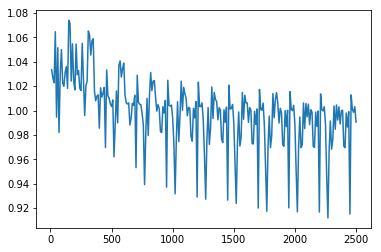

In [121]:
for epoch in range(0, Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1, label = data
        img0 = img0.float()
        img1 = img1.float()
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output0, output1 = nnet(img0, img1)
        contrastive_loss = criterion(output0, output1, label)
        contrastive_loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print("Epoch number {}\n Current loss {}\n".format(epoch, contrastive_loss.item()))
            iteration += 10
#            writer.add_scalar('data/train_loss', contrastive_loss.item(), iteration)
            counter.append(iteration)
            loss_history.append(contrastive_loss.item())
show_plot(counter, loss_history)

torch.save(nnet.state_dict(), '/home/astewart/repos/faceid/models/siamese.pt')

In [ ]:
nnet = SiameseNetwork().cuda()
nnet.load_state_dict(torch.load('/home/astewart/repos/faceid/models/siamese.pt'))

# Testing

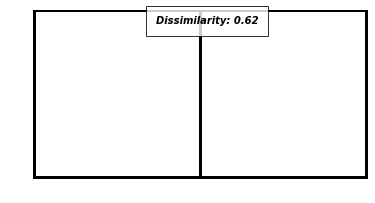

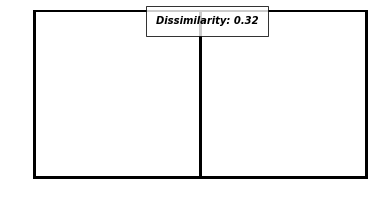

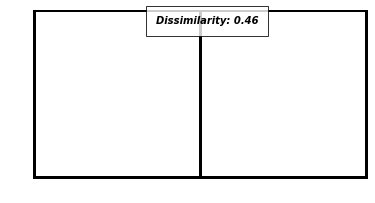

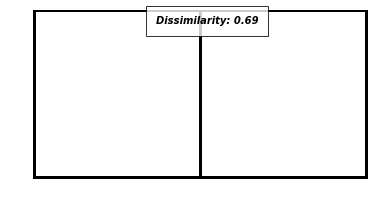

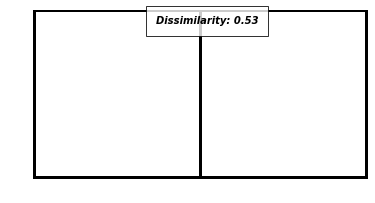

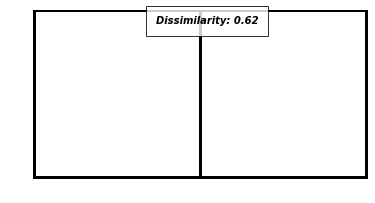

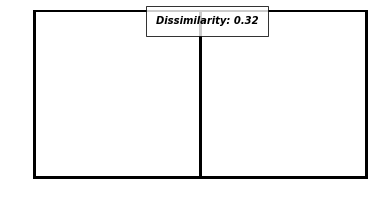

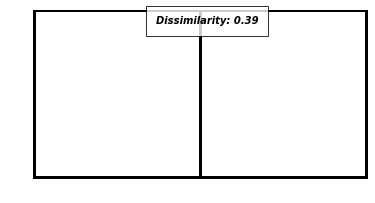

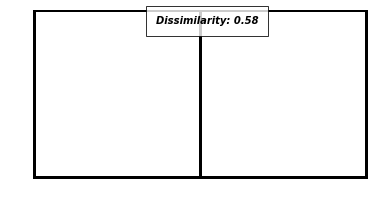

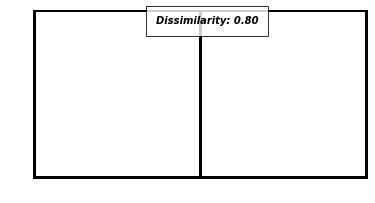

In [122]:
test_dataset = dset.ImageFolder(root=Config.test_dir)
faceid_dataset = FaceIdDataset(imageFolderDataset=test_dataset,
                               transform=transforms.Compose([transforms.ToTensor()]))

test_dataloader = DataLoader(faceid_dataset, num_workers=6, batch_size=1, shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0[:,:3,:,:],x1[:,:3,:,:]),0)
    
    output0, output1 = nnet(Variable(x0.float()).cuda(), Variable(x1.float()).cuda())
    l2_norm = F.pairwise_distance(output0, output1)
    imshow(torchvision.utils.make_grid(concatenated), 'Dissimilarity: {:.2f}'.format(l2_norm.item()))

In [158]:
#threshold = 0.6
# batch=32
# lr=0.0001
# epochs=50

# Threshold
---

In [135]:
test_dataset = dset.ImageFolder(root=Config.test_dir)
faceid_dataset = FaceIdDataset(imageFolderDataset=test_dataset,
                               transform=transforms.Compose([transforms.ToTensor()]))

test_dataloader = DataLoader(faceid_dataset, num_workers=6, batch_size=1, shuffle=False)
dataiter = iter(test_dataloader)

In [136]:
sensitivity = []
specificity = []
f1 = []
accuracy = []
y_true = np.array([])
distances = np.array([])

In [137]:
for x0, x1, label in dataiter:
    y_true = np.append(y_true, label.item())
    output0, output1 = nnet(Variable(x0.float()).cuda(), Variable(x1.float()).cuda())
    l2_norm = F.pairwise_distance(output0, output1)
    distances = np.append(distances, l2_norm.item())

In [138]:
thresholds = np.linspace(0.2,0.8,201)
for thresh in thresholds:
    y_pred = (distances > thresh).astype(float)
    sensitivity.append(precision_score(y_true, y_pred, pos_label=0))
    specificity.append(recall_score(y_true, y_pred, pos_label=1))
    f1.append(f1_score(y_true, y_pred, pos_label=0))
    accuracy.append(accuracy_score(y_true, y_pred))

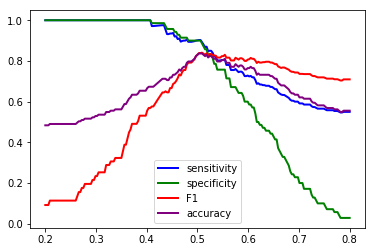

In [139]:
plt.plot(thresholds, sensitivity, marker='', color='blue', linewidth=2, label='sensitivity')
plt.plot(thresholds, specificity, marker='', color='green', linewidth=2, label='specificity')
plt.plot(thresholds, f1, marker='', color='red', linewidth=2, label='F1')
plt.plot(thresholds, accuracy, marker='', color='purple', linewidth=2, label='accuracy')
plt.legend()

In [146]:
spec = np.array(specificity)
idx = np.argwhere(spec == 1)[-1,:].item()

In [153]:
print("Threshold: {:.3f}\nSensitivity: {:.3f}\nSpecificity: {:.3f}\nAccuracy: {:.3f}".format(thresholds[idx],
                                                                                             sensitivity[idx],
                                                                                             specificity[idx],
                                                                                             accuracy[idx]))

Threshold: 0.407
Sensitivity: 1.000
Specificity: 1.000
Accuracy: 0.673
